<a href="https://colab.research.google.com/github/dms105-dshah/dagster-ml-pipeline/blob/main/A022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dagster dagster-webserver pandas scikit-learn matplotlib seaborn


In [2]:
!pip install dagster dagster-webserver pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.6/212.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from dagster import op, job


In [ ]:
@op
def load_data():
    url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
    df = pd.read_csv(url)
    df = df[['Pclass', 'Age', 'Fare', 'Survived']].dropna()
    print("Original rows:", len(df))
    df = df[df['Age'] > 30]
    print("After filter rows:", len(df))


    return df


In [ ]:
@op
def eda(df):
    sns.histplot(df['Age'])
    plt.show()
    return df


In [ ]:
@op
def compare_models(lr, dt, rf, knn):
    results = {
        "Logistic Regression": lr,
        "Decision Tree": dt,
        "Random Forest": rf,
        "KNN": knn
    }
    for model, acc in results.items():
        print(f"{model}: {acc:.3f}")
    return results


In [ ]:
@op
def split_data(df):
    X = df.drop("Survived", axis=1)
    y = df["Survived"]
    return train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
@op
def logistic_regression(data):
    X_train, X_test, y_train, y_test = data
    model = LogisticRegression()
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    print("Logistic Regression Accuracy:", acc)
    return accuracy_score(y_test, model.predict(X_test))


In [ ]:
@op
def decision_tree(data):
    X_train, X_test, y_train, y_test = data
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    print("Decision Tree Accuracy:", acc)
    DecisionTreeClassifier(random_state=42)
    return accuracy_score(y_test, model.predict(X_test))


In [ ]:
@op
def random_forest(data):
    X_train, X_test, y_train, y_test = data
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    print("Random Forest Accuracy:", acc)
    RandomForestClassifier(random_state=42)
    return accuracy_score(y_test, model.predict(X_test))


In [ ]:
@op
def knn(data):
    X_train, X_test, y_train, y_test = data
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    print("Knn Accuracy:", acc)
    return accuracy_score(y_test, model.predict(X_test))


In [ ]:
@op
def save_metrics(metrics):
    with open("metrics.json", "w") as f:
        json.dump(metrics, f, indent=4)
    print("Metrics saved to metrics.json")


In [ ]:
@op
def collect_metrics(lr, dt, rf, kn):
    metrics = {
        "Logistic Regression": lr,
        "Decision Tree": dt,
        "Random Forest": rf,
        "KNN": kn
    }
    return metrics


In [ ]:
@job
def ml_pipeline():
    df = load_data()
    clean_df = eda(df)
    split = split_data(clean_df)

    lr = logistic_regression(split)
    dt = decision_tree(split)
    rf = random_forest(split)
    kn = knn(split)

    metrics = collect_metrics(lr, dt, rf, kn)
    save_metrics(metrics)


In [ ]:
from pyngrok import ngrok

public_url = ngrok.connect(3000)
print("Dagster UI URL:", public_url)


Dagster UI URL: NgrokTunnel: "https://77f1f3957593.ngrok-free.app" -> "http://localhost:3000"


In [ ]:
!dagit -f pipeline.py &


2026-01-31 10:03:39 +0000 - dagit - WARNING - The `dagit` CLI command is deprecated and will be removed in dagster 2.0. Please use `dagster-webserver` instead.
2026-01-31 10:03:39 +0000 - dagit - INFO - Using temporary directory /content/.tmp_dagster_home_ottbq480 for storage. This will be removed when dagster-webserver exits.
2026-01-31 10:03:39 +0000 - dagit - INFO - To persist information across sessions, set the environment variable DAGSTER_HOME to a directory to use.
2026-01-31 10:03:44 +0000 - dagster.code_server - INFO - Starting Dagster code server for file pipeline.py in process 12489
2026-01-31 10:03:49 +0000 - dagster.code_server - INFO - Started Dagster code server for file pipeline.py in process 12489
2026-01-31 10:03:49 +0000 - dagit - INFO - Serving dagster-webserver on http://127.0.0.1:3000 in process 12446


In [1]:
from pyngrok import ngrok

ngrok.set_auth_token("1ttDRfY9TXMlg2rhH1Ft5h7nNwp_5jCyMtaASQNm1buj71Zz9")


2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - RUN_START - Started execution of run for "ml_pipeline".
2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - ENGINE_EVENT - Executing steps in process (pid: 259)
2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - RESOURCE_INIT_STARTED - Starting initialization of resources [io_manager].
2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - RESOURCE_INIT_SUCCESS - Finished initialization of resources [io_manager].
2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - LOGS_CAPTURED - Started capturing logs in process (pid: 259).
2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - load_data - STEP_START - Started execution of ste

Original rows: 714
After filter rows: 305


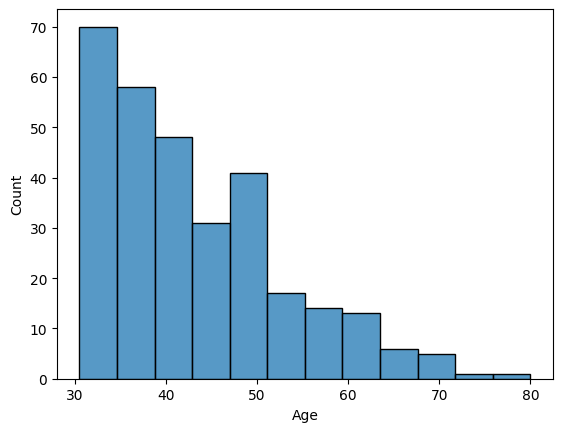

2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - eda - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - eda - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - eda - STEP_SUCCESS - Finished execution of step "eda" in 231ms.
2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - split_data - STEP_START - Started execution of step "split_data".
2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - split_data - LOADED_INPUT - Loaded input "df" using input manager "io_manager", from output "result" of step "eda"
2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4

Decision Tree Accuracy: 0.6557377049180327
Knn Accuracy: 0.6721311475409836
Logistic Regression Accuracy: 0.6721311475409836


2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - random_forest - STEP_OUTPUT - Yielded output "result" of type "Any". (Type check passed).
2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - random_forest - HANDLED_OUTPUT - Handled output "result" using IO manager "io_manager"
2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - random_forest - STEP_SUCCESS - Finished execution of step "random_forest" in 261ms.
2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - collect_metrics - STEP_START - Started execution of step "collect_metrics".
2026-01-28 07:30:32 +0000 - dagster - DEBUG - ml_pipeline - d2864add-f6c4-491b-9959-5dab7d2cdb06 - 259 - collect_metrics - LOADED_INPUT - Loaded input "lr" using input manager "io_manager", from output "result" of step "logistic_regression"
20

Random Forest Accuracy: 0.6721311475409836
Metrics saved to metrics.json


In [ ]:
from dagster import execute_job

result = ml_pipeline.execute_in_process()
result

